# Projeto VIII - Visão Computacional e Aprendizado de Máquina 
Autor: Luís Gabriel Pereira Condados

In [1]:
import cv2
import dlib
import numpy as np
import os

import matplotlib.pyplot as plt

Download do shape_predictor: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [2]:
DATA_BASE_DIR   = "dataset_B_FacialImages/"
CLOSED_FACE_DIR = "dataset_B_FacialImages/ClosedFace/"
OPEN_FACE_DIR   = "dataset_B_FacialImages/OpenFace/"
PREDICTOR_PATH  = "shape_predictor_68_face_landmarks.dat"

In [3]:
# Jaw line = 0 to 16
# Left Eyebrow = 17 to 21
# Right Eyebrow = 22 to 26
# Nose = 27 to 35
# Left Eye = 36 to 41
# Right Eye = 42 to 47
# Lips = 48 to 60
# Mouth Opening = 61 to 67
facial_landmarks_idxs = {
    "jaw_line":range(0,17),
    "left_eyebrow":range(17,22),
    "right_eyebrow":range(22,27),
    "nose":range(27,36),
    "left_eye":range(36,42),
    "right_eye":range(42,48),
    "lips":range(48,61),
    "mouth_opening":range(61,68)
}
facial_landmarks_idxs.keys()

dict_keys(['jaw_line', 'left_eyebrow', 'right_eyebrow', 'nose', 'left_eye', 'right_eye', 'lips', 'mouth_opening'])

## Funções Auxiliares

In [4]:
# detector de faces
detector  = dlib.get_frontal_face_detector()
# identificador dos landmarks
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [5]:
def eye_ratio(eye_points):
    eye_points = np.array(eye_points, dtype=float)
    
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[3] - eye_points[0])
    
    r = (A+B)/(2.0*C)
    
    return r

In [6]:
def get_landmarks(image):
    #deteção da face e dos landmarks
    #     det = detector(image)
    #     landmarks = predictor(image, det[0])
    landmarks = predictor(image, dlib.rectangle(0,0,100,100))
    pts = [(landmarks.part(n).x,landmarks.part(n).y) for n in range(68)]
    pts = np.array(pts, dtype='int')
    return pts

In [7]:
# obs.: supondo que existe apenas um rosto por imagem
def extract_features(image):    
    points = get_landmarks(image)
    
    left_eye_pts  = points[facial_landmarks_idxs['left_eye'],:]
    right_eye_pts = points[facial_landmarks_idxs['right_eye'],:]
    
    #proporção do olho esquerdo
    lratio = eye_ratio(left_eye_pts)
    #proporção do olho direito
    rratio = eye_ratio(right_eye_pts)
    
    return lratio, rratio

In [16]:
def draw_landmarks(image):
    img_out = image.copy()
    
    landmarks_pts = get_landmarks(image)
    
    for landmark in landmarks_pts:
        img_out = cv2.circle(img_out, tuple(landmark), 1 , 255, 1, cv2.FILLED)
    
    return img_out

In [9]:
def confusion_matrix(y_true, y_pred):
    pass

In [10]:
def plot_confusion_matrix(matrix):
    pass

In [11]:
def compute_metrics(y_true, y_pred, matrix=None):
    pass

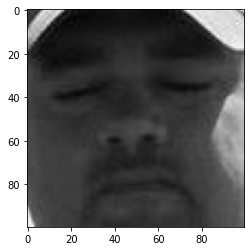

In [12]:
%matplotlib inline

img = cv2.imread("dataset_B_FacialImages/ClosedFace/closed_eye_0001.jpg_face_1.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, 'gray')

plt.show()

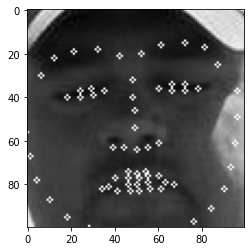

In [17]:
img_t = draw_landmarks(img)

plt.imshow(img_t, 'gray')
plt.show()

In [14]:
# dlib.rectangle(0,0,100,100)
extract_features(img)

(0.17848558013543783, 0.16666666666666666)

# Referências
[dlib] http://dlib.net/face_landmark_detection.py.html